# Machine Learning Foundation

## Course 5, Part d: Keras Intro LAB

## Using Keras to Build and Train Neural Networks

In this exercise we will use a neural network to predict diabetes using the Pima Diabetes Dataset.  We will start by training a Random Forest to get a performance baseline.  Then we will use the Keras package to quickly build and train a neural network and compare the performance.  We will see how different network structures affect the performance, training time, and level of overfitting (or underfitting).

## UCI Pima Diabetes Dataset

* UCI ML Repositiory (http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

The UCI Pima Diabetes Dataset which has 8 numerical predictors and a binary outcome.

In [1]:
#Setup
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
## Import Keras objects for Deep Learning
from keras.models  import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

In [3]:
## Load in the data set 
names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", "skin_thickness", "insulin", 
         "bmi", "pedigree_function", "age", "has_diabetes"]
diabetes_df = pd.read_csv('diabetes.csv', names=names, header=0)

In [4]:
# Take a peek at the data -- if there are lots of "NaN" you may have internet connectivity issues
print(diabetes_df.shape)
diabetes_df.sample(5)

(768, 9)


,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
160,4,151,90,38,0,29.7,0.294,36,0
593,2,82,52,22,115,28.5,1.699,25,0
98,6,93,50,30,64,28.7,0.356,23,0
567,6,92,62,32,126,32.0,0.085,46,0
95,6,144,72,27,228,33.9,0.255,40,0


In [5]:
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df["has_diabetes"].values

In [6]:
# Split the data to Train, and Test (75%, 25%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11111)

In [7]:
np.mean(y), np.mean(1-y)

(0.3489583333333333, 0.6510416666666666)

Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.
## Exercise 1: Get a baseline performance using Random Forest
To begin, and get a baseline for classifier performance:
1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.

In [8]:
### BEGIN SOLUTION
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [9]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)


print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.776
roc-auc is 0.829


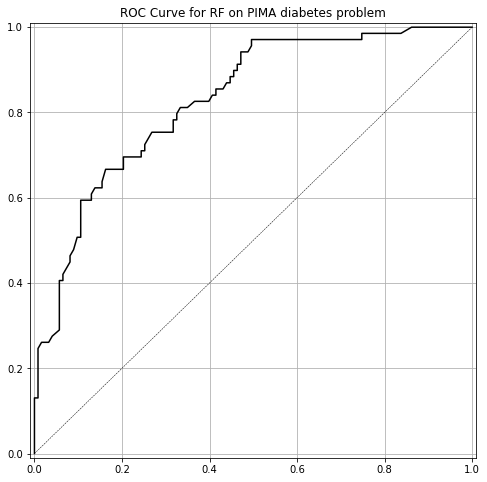

In [10]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])
plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')
### END SOLUTION

## Build a Single Hidden Layer Neural Network

We will use the Sequential model to quickly build a neural network.  Our first network will be a single layer network.  We have 8 variables, so we set the input shape to 8.  Let's start by having a single hidden layer with 12 nodes.

In [11]:
## First let's normalize the data
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [12]:
len(X_train_norm)

576

In [13]:
len(X_test_norm)

192

In [14]:
# Define the Model 
# Input size is 8-dimensional
# 1 hidden layer, 12 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)

model_1 = Sequential()
model_1.add(Dense(12,input_shape = (8,),activation = 'sigmoid'))
model_1.add(Dense(1,activation='sigmoid'))

In [15]:
#  This is a nice tool to view the model you have created and count the parameters

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                108       
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


### Comprehension question:
Why do we have 121 parameters?  Does that make sense?

Let's fit our model for 200 epochs.

In [16]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.
# SGD is stochastic gradient descent
model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=200)
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

Epoch 1/200
18/18 [==============================] - 0s 8ms/step - loss: 0.9801 - accuracy: 0.3472 - val_loss: 0.9736 - val_accuracy: 0.3594
Epoch 2/200
18/18 [==============================] - 0s 2ms/step - loss: 0.9491 - accuracy: 0.3490 - val_loss: 0.9448 - val_accuracy: 0.3594
Epoch 3/200
18/18 [==============================] - 0s 2ms/step - loss: 0.9208 - accuracy: 0.3507 - val_loss: 0.9184 - val_accuracy: 0.3594
Epoch 4/200
18/18 [==============================] - 0s 2ms/step - loss: 0.8949 - accuracy: 0.3507 - val_loss: 0.8945 - val_accuracy: 0.3542
Epoch 5/200
18/18 [==============================] - 0s 2ms/step - loss: 0.8713 - accuracy: 0.3524 - val_loss: 0.8727 - val_accuracy: 0.3490
Epoch 6/200
18/18 [==============================] - 0s 2ms/step - loss: 0.8499 - accuracy: 0.3611 - val_loss: 0.8528 - val_accuracy: 0.3385
Epoch 7/200
18/18 [==============================] - 0s 2ms/step - loss: 0.8304 - accuracy: 0.3663 - val_loss: 0.8349 - val_accuracy: 0.3125
Epoch 8/200
1

Epoch 59/200
18/18 [==============================] - 0s 1ms/step - loss: 0.6246 - accuracy: 0.6788 - val_loss: 0.6455 - val_accuracy: 0.6562
Epoch 60/200
18/18 [==============================] - 0s 2ms/step - loss: 0.6239 - accuracy: 0.6788 - val_loss: 0.6448 - val_accuracy: 0.6562
Epoch 61/200
18/18 [==============================] - 0s 2ms/step - loss: 0.6232 - accuracy: 0.6753 - val_loss: 0.6441 - val_accuracy: 0.6562
Epoch 62/200
18/18 [==============================] - 0s 2ms/step - loss: 0.6225 - accuracy: 0.6753 - val_loss: 0.6435 - val_accuracy: 0.6510
Epoch 63/200
18/18 [==============================] - 0s 2ms/step - loss: 0.6218 - accuracy: 0.6771 - val_loss: 0.6428 - val_accuracy: 0.6510
Epoch 64/200
18/18 [==============================] - 0s 2ms/step - loss: 0.6212 - accuracy: 0.6771 - val_loss: 0.6421 - val_accuracy: 0.6510
Epoch 65/200
18/18 [==============================] - 0s 2ms/step - loss: 0.6205 - accuracy: 0.6753 - val_loss: 0.6414 - val_accuracy: 0.6562
Epoch 

18/18 [==============================] - 0s 2ms/step - loss: 0.5913 - accuracy: 0.6788 - val_loss: 0.6120 - val_accuracy: 0.6667
Epoch 117/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5908 - accuracy: 0.6788 - val_loss: 0.6114 - val_accuracy: 0.6667
Epoch 118/200
18/18 [==============================] - 0s 3ms/step - loss: 0.5902 - accuracy: 0.6788 - val_loss: 0.6109 - val_accuracy: 0.6667
Epoch 119/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5897 - accuracy: 0.6788 - val_loss: 0.6104 - val_accuracy: 0.6667
Epoch 120/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5892 - accuracy: 0.6788 - val_loss: 0.6099 - val_accuracy: 0.6667
Epoch 121/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5887 - accuracy: 0.6788 - val_loss: 0.6094 - val_accuracy: 0.6667
Epoch 122/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5882 - accuracy: 0.6788 - val_loss: 0.6089 - val_accuracy: 0.6667
Epoch 123/200

18/18 [==============================] - 0s 2ms/step - loss: 0.5646 - accuracy: 0.6997 - val_loss: 0.5852 - val_accuracy: 0.6927
Epoch 174/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5642 - accuracy: 0.6997 - val_loss: 0.5848 - val_accuracy: 0.6927
Epoch 175/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5637 - accuracy: 0.6997 - val_loss: 0.5843 - val_accuracy: 0.6927
Epoch 176/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5633 - accuracy: 0.6997 - val_loss: 0.5839 - val_accuracy: 0.6927
Epoch 177/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5629 - accuracy: 0.6997 - val_loss: 0.5835 - val_accuracy: 0.6927
Epoch 178/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5625 - accuracy: 0.6979 - val_loss: 0.5831 - val_accuracy: 0.6927
Epoch 179/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5621 - accuracy: 0.6979 - val_loss: 0.5827 - val_accuracy: 0.6927
Epoch 180/200

In [17]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

#y_pred_class_nn_1 = model_1.predict_classes(X_test_norm)
y_pred_prob_nn_1 = model_1.predict(X_test_norm)

6/6 [==============================] - 0s 2ms/step


In [18]:
y_pred_class_nn_1=pd.DataFrame(y_pred_prob_nn_1)

In [19]:
y_pred_class_nn_1=np.array(y_pred_class_nn_1[0].apply(lambda x : 0 if x<0.5 else 1))

In [20]:
# Let's check out the outputs to get a feel for how keras apis work.
y_pred_class_nn_1[:10]

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int64)

In [21]:
y_pred_class_nn_1=y_pred_class_nn_1.reshape(-1,1)

In [22]:
y_pred_prob_nn_1[:10]

array([[0.4613693 ],
       [0.51292455],
       [0.3384255 ],
       [0.24746878],
       [0.2781613 ],
       [0.4702617 ],
       [0.21889645],
       [0.31960782],
       [0.6152793 ],
       [0.29782355]], dtype=float32)

accuracy is 0.703
roc-auc is 0.759


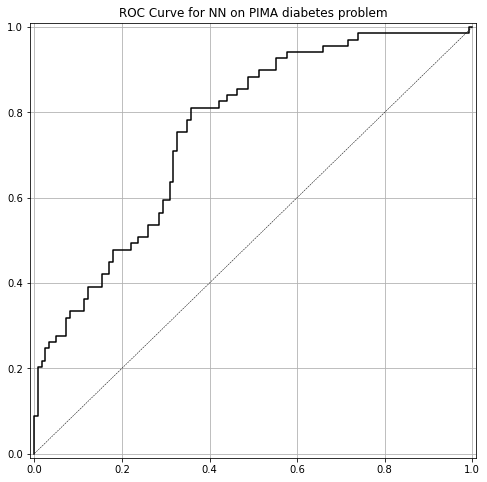

In [23]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

There may be some variation in exact numbers due to randomness, but you should get results in the same ballpark as the Random Forest - between 75% and 85% accuracy, between .8 and .9 for AUC.

Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.

In [24]:
run_hist_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.

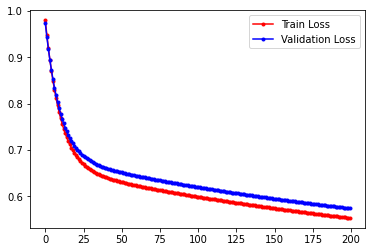

In [25]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend();

Looks like the losses are still going down on both the training set and the validation set.  This suggests that the model might benefit from further training.  Let's train the model a little more and see what happens. Note that it will pick up from where it left off. Train for 1000 more epochs.

In [26]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000)

Epoch 1/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.5532 - accuracy: 0.6979 - val_loss: 0.5739 - val_accuracy: 0.7031
Epoch 2/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.5528 - accuracy: 0.6997 - val_loss: 0.5735 - val_accuracy: 0.7031
Epoch 3/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.5524 - accuracy: 0.6997 - val_loss: 0.5731 - val_accuracy: 0.7031
Epoch 4/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.5520 - accuracy: 0.7014 - val_loss: 0.5728 - val_accuracy: 0.7031
Epoch 5/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.5516 - accuracy: 0.7031 - val_loss: 0.5724 - val_accuracy: 0.7031
Epoch 6/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.5512 - accuracy: 0.7031 - val_loss: 0.5720 - val_accuracy: 0.6979
Epoch 7/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.5508 - accuracy: 0.7031 - val_loss: 0.5716 - val_accuracy: 0.6979
Epoch 

18/18 [==============================] - 0s 2ms/step - loss: 0.5328 - accuracy: 0.7378 - val_loss: 0.5543 - val_accuracy: 0.7083
Epoch 59/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.5325 - accuracy: 0.7396 - val_loss: 0.5540 - val_accuracy: 0.7083
Epoch 60/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.5322 - accuracy: 0.7378 - val_loss: 0.5537 - val_accuracy: 0.7083
Epoch 61/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.5319 - accuracy: 0.7396 - val_loss: 0.5534 - val_accuracy: 0.7083
Epoch 62/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.5316 - accuracy: 0.7413 - val_loss: 0.5531 - val_accuracy: 0.7083
Epoch 63/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.5312 - accuracy: 0.7431 - val_loss: 0.5528 - val_accuracy: 0.7083
Epoch 64/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.5309 - accuracy: 0.7431 - val_loss: 0.5525 - val_accuracy: 0.7083
Epoch 65/1000

18/18 [==============================] - 0s 2ms/step - loss: 0.5163 - accuracy: 0.7604 - val_loss: 0.5388 - val_accuracy: 0.7344
Epoch 116/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.5160 - accuracy: 0.7604 - val_loss: 0.5385 - val_accuracy: 0.7344
Epoch 117/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.5157 - accuracy: 0.7604 - val_loss: 0.5383 - val_accuracy: 0.7344
Epoch 118/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.5155 - accuracy: 0.7604 - val_loss: 0.5381 - val_accuracy: 0.7344
Epoch 119/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.5152 - accuracy: 0.7604 - val_loss: 0.5378 - val_accuracy: 0.7344
Epoch 120/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.5150 - accuracy: 0.7604 - val_loss: 0.5376 - val_accuracy: 0.7344
Epoch 121/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.5147 - accuracy: 0.7604 - val_loss: 0.5374 - val_accuracy: 0.7344
Epoch 1

Epoch 172/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.5031 - accuracy: 0.7622 - val_loss: 0.5268 - val_accuracy: 0.7500
Epoch 173/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.5029 - accuracy: 0.7622 - val_loss: 0.5266 - val_accuracy: 0.7500
Epoch 174/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.5027 - accuracy: 0.7622 - val_loss: 0.5264 - val_accuracy: 0.7500
Epoch 175/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.5025 - accuracy: 0.7622 - val_loss: 0.5262 - val_accuracy: 0.7552
Epoch 176/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.5023 - accuracy: 0.7622 - val_loss: 0.5261 - val_accuracy: 0.7552
Epoch 177/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.5021 - accuracy: 0.7622 - val_loss: 0.5259 - val_accuracy: 0.7552
Epoch 178/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.5019 - accuracy: 0.7639 - val_loss: 0.5257 - val_accuracy:

Epoch 229/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4928 - accuracy: 0.7691 - val_loss: 0.5177 - val_accuracy: 0.7552
Epoch 230/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4927 - accuracy: 0.7691 - val_loss: 0.5176 - val_accuracy: 0.7604
Epoch 231/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4925 - accuracy: 0.7691 - val_loss: 0.5174 - val_accuracy: 0.7604
Epoch 232/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4924 - accuracy: 0.7691 - val_loss: 0.5173 - val_accuracy: 0.7604
Epoch 233/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4922 - accuracy: 0.7691 - val_loss: 0.5172 - val_accuracy: 0.7604
Epoch 234/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4921 - accuracy: 0.7691 - val_loss: 0.5170 - val_accuracy: 0.7604
Epoch 235/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4919 - accuracy: 0.7708 - val_loss: 0.5169 - val_accuracy:

Epoch 286/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4850 - accuracy: 0.7760 - val_loss: 0.5109 - val_accuracy: 0.7604
Epoch 287/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4848 - accuracy: 0.7760 - val_loss: 0.5108 - val_accuracy: 0.7604
Epoch 288/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4847 - accuracy: 0.7760 - val_loss: 0.5107 - val_accuracy: 0.7604
Epoch 289/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4846 - accuracy: 0.7760 - val_loss: 0.5106 - val_accuracy: 0.7604
Epoch 290/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4845 - accuracy: 0.7760 - val_loss: 0.5105 - val_accuracy: 0.7604
Epoch 291/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4844 - accuracy: 0.7760 - val_loss: 0.5104 - val_accuracy: 0.7604
Epoch 292/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4842 - accuracy: 0.7760 - val_loss: 0.5103 - val_accuracy:

Epoch 343/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4790 - accuracy: 0.7778 - val_loss: 0.5059 - val_accuracy: 0.7552
Epoch 344/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4789 - accuracy: 0.7778 - val_loss: 0.5059 - val_accuracy: 0.7552
Epoch 345/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4788 - accuracy: 0.7778 - val_loss: 0.5058 - val_accuracy: 0.7552
Epoch 346/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4787 - accuracy: 0.7778 - val_loss: 0.5057 - val_accuracy: 0.7500
Epoch 347/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4786 - accuracy: 0.7778 - val_loss: 0.5056 - val_accuracy: 0.7500
Epoch 348/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4785 - accuracy: 0.7778 - val_loss: 0.5056 - val_accuracy: 0.7500
Epoch 349/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4784 - accuracy: 0.7778 - val_loss: 0.5055 - val_accuracy:

Epoch 400/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4744 - accuracy: 0.7812 - val_loss: 0.5022 - val_accuracy: 0.7448
Epoch 401/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4743 - accuracy: 0.7795 - val_loss: 0.5021 - val_accuracy: 0.7448
Epoch 402/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4743 - accuracy: 0.7812 - val_loss: 0.5021 - val_accuracy: 0.7448
Epoch 403/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4742 - accuracy: 0.7795 - val_loss: 0.5020 - val_accuracy: 0.7448
Epoch 404/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4741 - accuracy: 0.7795 - val_loss: 0.5020 - val_accuracy: 0.7500
Epoch 405/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4741 - accuracy: 0.7795 - val_loss: 0.5019 - val_accuracy: 0.7500
Epoch 406/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4740 - accuracy: 0.7795 - val_loss: 0.5019 - val_accuracy:

Epoch 457/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4709 - accuracy: 0.7812 - val_loss: 0.4994 - val_accuracy: 0.7500
Epoch 458/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4709 - accuracy: 0.7795 - val_loss: 0.4994 - val_accuracy: 0.7500
Epoch 459/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4708 - accuracy: 0.7812 - val_loss: 0.4993 - val_accuracy: 0.7500
Epoch 460/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4708 - accuracy: 0.7812 - val_loss: 0.4993 - val_accuracy: 0.7500
Epoch 461/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4707 - accuracy: 0.7795 - val_loss: 0.4992 - val_accuracy: 0.7500
Epoch 462/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4707 - accuracy: 0.7795 - val_loss: 0.4992 - val_accuracy: 0.7500
Epoch 463/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4706 - accuracy: 0.7795 - val_loss: 0.4992 - val_accuracy:

Epoch 514/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4683 - accuracy: 0.7812 - val_loss: 0.4973 - val_accuracy: 0.7448
Epoch 515/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4682 - accuracy: 0.7812 - val_loss: 0.4973 - val_accuracy: 0.7448
Epoch 516/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4682 - accuracy: 0.7812 - val_loss: 0.4972 - val_accuracy: 0.7448
Epoch 517/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4682 - accuracy: 0.7812 - val_loss: 0.4972 - val_accuracy: 0.7448
Epoch 518/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4681 - accuracy: 0.7812 - val_loss: 0.4972 - val_accuracy: 0.7448
Epoch 519/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4680 - accuracy: 0.7812 - val_loss: 0.4972 - val_accuracy: 0.7448
Epoch 520/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4680 - accuracy: 0.7812 - val_loss: 0.4971 - val_accuracy:

Epoch 571/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4662 - accuracy: 0.7795 - val_loss: 0.4957 - val_accuracy: 0.7500
Epoch 572/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4661 - accuracy: 0.7795 - val_loss: 0.4957 - val_accuracy: 0.7500
Epoch 573/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4661 - accuracy: 0.7795 - val_loss: 0.4957 - val_accuracy: 0.7500
Epoch 574/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4661 - accuracy: 0.7795 - val_loss: 0.4956 - val_accuracy: 0.7500
Epoch 575/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4661 - accuracy: 0.7812 - val_loss: 0.4956 - val_accuracy: 0.7500
Epoch 576/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4660 - accuracy: 0.7795 - val_loss: 0.4956 - val_accuracy: 0.7500
Epoch 577/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4660 - accuracy: 0.7795 - val_loss: 0.4956 - val_accuracy:

Epoch 628/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4646 - accuracy: 0.7812 - val_loss: 0.4945 - val_accuracy: 0.7448
Epoch 629/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4645 - accuracy: 0.7812 - val_loss: 0.4944 - val_accuracy: 0.7448
Epoch 630/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4645 - accuracy: 0.7812 - val_loss: 0.4944 - val_accuracy: 0.7448
Epoch 631/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4645 - accuracy: 0.7812 - val_loss: 0.4944 - val_accuracy: 0.7448
Epoch 632/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4645 - accuracy: 0.7812 - val_loss: 0.4944 - val_accuracy: 0.7448
Epoch 633/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4644 - accuracy: 0.7812 - val_loss: 0.4944 - val_accuracy: 0.7448
Epoch 634/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4644 - accuracy: 0.7812 - val_loss: 0.4943 - val_accuracy:

Epoch 685/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4633 - accuracy: 0.7812 - val_loss: 0.4935 - val_accuracy: 0.7448
Epoch 686/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4632 - accuracy: 0.7812 - val_loss: 0.4935 - val_accuracy: 0.7448
Epoch 687/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4632 - accuracy: 0.7812 - val_loss: 0.4935 - val_accuracy: 0.7448
Epoch 688/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4632 - accuracy: 0.7812 - val_loss: 0.4934 - val_accuracy: 0.7448
Epoch 689/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4632 - accuracy: 0.7812 - val_loss: 0.4934 - val_accuracy: 0.7448
Epoch 690/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4632 - accuracy: 0.7812 - val_loss: 0.4934 - val_accuracy: 0.7448
Epoch 691/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4631 - accuracy: 0.7812 - val_loss: 0.4934 - val_accuracy:

Epoch 742/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4622 - accuracy: 0.7795 - val_loss: 0.4927 - val_accuracy: 0.7552
Epoch 743/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4622 - accuracy: 0.7795 - val_loss: 0.4927 - val_accuracy: 0.7552
Epoch 744/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4622 - accuracy: 0.7795 - val_loss: 0.4927 - val_accuracy: 0.7552
Epoch 745/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4622 - accuracy: 0.7795 - val_loss: 0.4927 - val_accuracy: 0.7552
Epoch 746/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4622 - accuracy: 0.7795 - val_loss: 0.4927 - val_accuracy: 0.7552
Epoch 747/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4622 - accuracy: 0.7795 - val_loss: 0.4927 - val_accuracy: 0.7552
Epoch 748/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4621 - accuracy: 0.7795 - val_loss: 0.4926 - val_accuracy:

Epoch 799/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4614 - accuracy: 0.7778 - val_loss: 0.4921 - val_accuracy: 0.7552
Epoch 800/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4614 - accuracy: 0.7778 - val_loss: 0.4921 - val_accuracy: 0.7552
Epoch 801/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4614 - accuracy: 0.7778 - val_loss: 0.4921 - val_accuracy: 0.7552
Epoch 802/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4614 - accuracy: 0.7778 - val_loss: 0.4921 - val_accuracy: 0.7552
Epoch 803/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4613 - accuracy: 0.7778 - val_loss: 0.4921 - val_accuracy: 0.7552
Epoch 804/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4613 - accuracy: 0.7778 - val_loss: 0.4921 - val_accuracy: 0.7552
Epoch 805/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4613 - accuracy: 0.7778 - val_loss: 0.4920 - val_accuracy:

Epoch 856/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4607 - accuracy: 0.7795 - val_loss: 0.4916 - val_accuracy: 0.7552
Epoch 857/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4607 - accuracy: 0.7795 - val_loss: 0.4916 - val_accuracy: 0.7552
Epoch 858/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4607 - accuracy: 0.7795 - val_loss: 0.4916 - val_accuracy: 0.7552
Epoch 859/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4606 - accuracy: 0.7795 - val_loss: 0.4916 - val_accuracy: 0.7552
Epoch 860/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4606 - accuracy: 0.7795 - val_loss: 0.4916 - val_accuracy: 0.7552
Epoch 861/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4606 - accuracy: 0.7795 - val_loss: 0.4916 - val_accuracy: 0.7552
Epoch 862/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4606 - accuracy: 0.7795 - val_loss: 0.4916 - val_accuracy:

Epoch 913/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4601 - accuracy: 0.7795 - val_loss: 0.4912 - val_accuracy: 0.7604
Epoch 914/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4601 - accuracy: 0.7795 - val_loss: 0.4912 - val_accuracy: 0.7604
Epoch 915/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4601 - accuracy: 0.7795 - val_loss: 0.4912 - val_accuracy: 0.7604
Epoch 916/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4601 - accuracy: 0.7812 - val_loss: 0.4912 - val_accuracy: 0.7604
Epoch 917/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4600 - accuracy: 0.7795 - val_loss: 0.4912 - val_accuracy: 0.7604
Epoch 918/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.4600 - accuracy: 0.7812 - val_loss: 0.4912 - val_accuracy: 0.7604
Epoch 919/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4600 - accuracy: 0.7795 - val_loss: 0.4912 - val_accuracy:

Epoch 970/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4596 - accuracy: 0.7830 - val_loss: 0.4909 - val_accuracy: 0.7604
Epoch 971/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4596 - accuracy: 0.7830 - val_loss: 0.4909 - val_accuracy: 0.7604
Epoch 972/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4596 - accuracy: 0.7830 - val_loss: 0.4908 - val_accuracy: 0.7604
Epoch 973/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4596 - accuracy: 0.7830 - val_loss: 0.4908 - val_accuracy: 0.7604
Epoch 974/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4596 - accuracy: 0.7830 - val_loss: 0.4908 - val_accuracy: 0.7604
Epoch 975/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4595 - accuracy: 0.7830 - val_loss: 0.4908 - val_accuracy: 0.7604
Epoch 976/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4595 - accuracy: 0.7830 - val_loss: 0.4908 - val_accuracy:

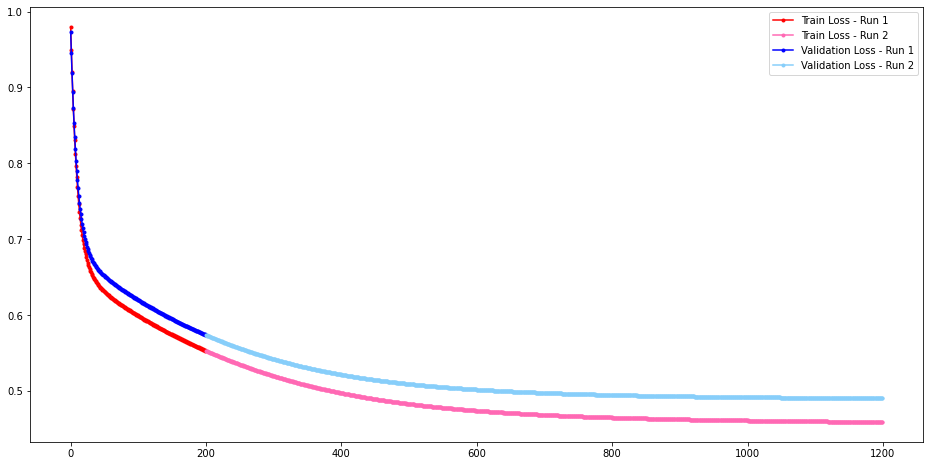

In [27]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Note that this graph begins where the other left off.  While the training loss is still going down, it looks like the validation loss has stabilized (or even gotten worse!).  This suggests that our network will not benefit from further training.  What is the appropriate number of epochs?

## Exercise 2
For this exercise, do the following in the cells below:
- Build a model with two hidden layers, each with 6 nodes
- Use the "relu" activation function for the hidden layers, and "sigmoid" for the final layer
- Use a learning rate of .003 and train for 1500 epochs
- Graph the trajectory of the loss functions, accuracy on both train and test set
- Plot the roc curve for the predictions

Experiment with different learning rates, numbers of epochs, and network structures

In [28]:
### BEGIN SOLUTION
model_2 = Sequential()
model_2.add(Dense(6, input_shape=(8,), activation="relu"))
model_2.add(Dense(6,  activation="relu"))
model_2.add(Dense(1, activation="sigmoid"))

model_2.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_2 = model_2.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1500)

Epoch 1/1500
18/18 [==============================] - 0s 7ms/step - loss: 0.6821 - accuracy: 0.6024 - val_loss: 0.6808 - val_accuracy: 0.5729
Epoch 2/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6762 - accuracy: 0.6181 - val_loss: 0.6751 - val_accuracy: 0.6042
Epoch 3/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6707 - accuracy: 0.6302 - val_loss: 0.6697 - val_accuracy: 0.6406
Epoch 4/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6656 - accuracy: 0.6354 - val_loss: 0.6646 - val_accuracy: 0.6562
Epoch 5/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6608 - accuracy: 0.6562 - val_loss: 0.6599 - val_accuracy: 0.6615
Epoch 6/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6562 - accuracy: 0.6649 - val_loss: 0.6554 - val_accuracy: 0.6771
Epoch 7/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.6518 - accuracy: 0.6649 - val_loss: 0.6511 - val_accuracy: 0.6771
Epoch 

18/18 [==============================] - 0s 2ms/step - loss: 0.5494 - accuracy: 0.6875 - val_loss: 0.5633 - val_accuracy: 0.6667
Epoch 59/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.5484 - accuracy: 0.6875 - val_loss: 0.5625 - val_accuracy: 0.6719
Epoch 60/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5474 - accuracy: 0.6892 - val_loss: 0.5618 - val_accuracy: 0.6719
Epoch 61/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5463 - accuracy: 0.6910 - val_loss: 0.5610 - val_accuracy: 0.6719
Epoch 62/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5454 - accuracy: 0.6910 - val_loss: 0.5603 - val_accuracy: 0.6771
Epoch 63/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.5443 - accuracy: 0.6927 - val_loss: 0.5595 - val_accuracy: 0.6771
Epoch 64/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5434 - accuracy: 0.6910 - val_loss: 0.5588 - val_accuracy: 0.6927
Epoch 65/1500

18/18 [==============================] - 0s 2ms/step - loss: 0.5101 - accuracy: 0.7049 - val_loss: 0.5333 - val_accuracy: 0.7135
Epoch 116/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5097 - accuracy: 0.7083 - val_loss: 0.5329 - val_accuracy: 0.7188
Epoch 117/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5092 - accuracy: 0.7083 - val_loss: 0.5326 - val_accuracy: 0.7188
Epoch 118/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5088 - accuracy: 0.7101 - val_loss: 0.5323 - val_accuracy: 0.7188
Epoch 119/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5084 - accuracy: 0.7101 - val_loss: 0.5320 - val_accuracy: 0.7188
Epoch 120/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5080 - accuracy: 0.7101 - val_loss: 0.5316 - val_accuracy: 0.7188
Epoch 121/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.5075 - accuracy: 0.7101 - val_loss: 0.5313 - val_accuracy: 0.7188
Epoch 1

Epoch 172/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4905 - accuracy: 0.7569 - val_loss: 0.5206 - val_accuracy: 0.7448
Epoch 173/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4903 - accuracy: 0.7569 - val_loss: 0.5204 - val_accuracy: 0.7448
Epoch 174/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4900 - accuracy: 0.7569 - val_loss: 0.5203 - val_accuracy: 0.7448
Epoch 175/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4897 - accuracy: 0.7569 - val_loss: 0.5201 - val_accuracy: 0.7448
Epoch 176/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4895 - accuracy: 0.7587 - val_loss: 0.5200 - val_accuracy: 0.7448
Epoch 177/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4892 - accuracy: 0.7569 - val_loss: 0.5199 - val_accuracy: 0.7448
Epoch 178/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4890 - accuracy: 0.7587 - val_loss: 0.5198 - val_accuracy:

Epoch 229/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4777 - accuracy: 0.7674 - val_loss: 0.5150 - val_accuracy: 0.7500
Epoch 230/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4776 - accuracy: 0.7674 - val_loss: 0.5150 - val_accuracy: 0.7552
Epoch 231/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4773 - accuracy: 0.7656 - val_loss: 0.5149 - val_accuracy: 0.7552
Epoch 232/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4772 - accuracy: 0.7691 - val_loss: 0.5149 - val_accuracy: 0.7552
Epoch 233/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4770 - accuracy: 0.7708 - val_loss: 0.5148 - val_accuracy: 0.7552
Epoch 234/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4768 - accuracy: 0.7708 - val_loss: 0.5148 - val_accuracy: 0.7552
Epoch 235/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4766 - accuracy: 0.7691 - val_loss: 0.5147 - val_accuracy:

Epoch 286/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4677 - accuracy: 0.7691 - val_loss: 0.5142 - val_accuracy: 0.7500
Epoch 287/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4676 - accuracy: 0.7691 - val_loss: 0.5142 - val_accuracy: 0.7500
Epoch 288/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4674 - accuracy: 0.7708 - val_loss: 0.5142 - val_accuracy: 0.7448
Epoch 289/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4673 - accuracy: 0.7691 - val_loss: 0.5142 - val_accuracy: 0.7448
Epoch 290/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4671 - accuracy: 0.7691 - val_loss: 0.5142 - val_accuracy: 0.7448
Epoch 291/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4669 - accuracy: 0.7674 - val_loss: 0.5142 - val_accuracy: 0.7448
Epoch 292/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4667 - accuracy: 0.7674 - val_loss: 0.5142 - val_accuracy:

Epoch 343/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4586 - accuracy: 0.7795 - val_loss: 0.5150 - val_accuracy: 0.7396
Epoch 344/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4584 - accuracy: 0.7812 - val_loss: 0.5150 - val_accuracy: 0.7344
Epoch 345/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4583 - accuracy: 0.7795 - val_loss: 0.5150 - val_accuracy: 0.7344
Epoch 346/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4581 - accuracy: 0.7812 - val_loss: 0.5150 - val_accuracy: 0.7344
Epoch 347/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4579 - accuracy: 0.7795 - val_loss: 0.5150 - val_accuracy: 0.7344
Epoch 348/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4578 - accuracy: 0.7812 - val_loss: 0.5151 - val_accuracy: 0.7344
Epoch 349/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4576 - accuracy: 0.7830 - val_loss: 0.5151 - val_accuracy:

Epoch 400/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4500 - accuracy: 0.7917 - val_loss: 0.5166 - val_accuracy: 0.7448
Epoch 401/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4498 - accuracy: 0.7917 - val_loss: 0.5167 - val_accuracy: 0.7448
Epoch 402/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4497 - accuracy: 0.7917 - val_loss: 0.5167 - val_accuracy: 0.7448
Epoch 403/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4495 - accuracy: 0.7917 - val_loss: 0.5168 - val_accuracy: 0.7448
Epoch 404/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4494 - accuracy: 0.7917 - val_loss: 0.5169 - val_accuracy: 0.7448
Epoch 405/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4493 - accuracy: 0.7917 - val_loss: 0.5169 - val_accuracy: 0.7448
Epoch 406/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4491 - accuracy: 0.7917 - val_loss: 0.5170 - val_accuracy:

Epoch 457/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4430 - accuracy: 0.7934 - val_loss: 0.5186 - val_accuracy: 0.7500
Epoch 458/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4429 - accuracy: 0.7917 - val_loss: 0.5186 - val_accuracy: 0.7500
Epoch 459/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4428 - accuracy: 0.7951 - val_loss: 0.5187 - val_accuracy: 0.7500
Epoch 460/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4427 - accuracy: 0.7951 - val_loss: 0.5187 - val_accuracy: 0.7500
Epoch 461/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4426 - accuracy: 0.7934 - val_loss: 0.5188 - val_accuracy: 0.7500
Epoch 462/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4425 - accuracy: 0.7934 - val_loss: 0.5188 - val_accuracy: 0.7500
Epoch 463/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4424 - accuracy: 0.7951 - val_loss: 0.5188 - val_accuracy:

Epoch 514/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4381 - accuracy: 0.8003 - val_loss: 0.5209 - val_accuracy: 0.7552
Epoch 515/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4380 - accuracy: 0.8003 - val_loss: 0.5209 - val_accuracy: 0.7552
Epoch 516/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4379 - accuracy: 0.8003 - val_loss: 0.5209 - val_accuracy: 0.7552
Epoch 517/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4379 - accuracy: 0.8003 - val_loss: 0.5210 - val_accuracy: 0.7552
Epoch 518/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4378 - accuracy: 0.8003 - val_loss: 0.5210 - val_accuracy: 0.7552
Epoch 519/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4377 - accuracy: 0.7986 - val_loss: 0.5211 - val_accuracy: 0.7552
Epoch 520/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4377 - accuracy: 0.7986 - val_loss: 0.5211 - val_accuracy:

Epoch 571/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4347 - accuracy: 0.8003 - val_loss: 0.5229 - val_accuracy: 0.7552
Epoch 572/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4346 - accuracy: 0.8003 - val_loss: 0.5229 - val_accuracy: 0.7552
Epoch 573/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4346 - accuracy: 0.8003 - val_loss: 0.5229 - val_accuracy: 0.7552
Epoch 574/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4345 - accuracy: 0.8003 - val_loss: 0.5230 - val_accuracy: 0.7552
Epoch 575/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4345 - accuracy: 0.8003 - val_loss: 0.5230 - val_accuracy: 0.7552
Epoch 576/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4344 - accuracy: 0.8003 - val_loss: 0.5230 - val_accuracy: 0.7552
Epoch 577/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4344 - accuracy: 0.8003 - val_loss: 0.5231 - val_accuracy:

Epoch 628/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4325 - accuracy: 0.7986 - val_loss: 0.5252 - val_accuracy: 0.7604
Epoch 629/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4324 - accuracy: 0.7969 - val_loss: 0.5253 - val_accuracy: 0.7604
Epoch 630/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4323 - accuracy: 0.8003 - val_loss: 0.5253 - val_accuracy: 0.7604
Epoch 631/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4324 - accuracy: 0.7986 - val_loss: 0.5253 - val_accuracy: 0.7604
Epoch 632/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4323 - accuracy: 0.8003 - val_loss: 0.5254 - val_accuracy: 0.7604
Epoch 633/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4323 - accuracy: 0.7986 - val_loss: 0.5254 - val_accuracy: 0.7604
Epoch 634/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4323 - accuracy: 0.8003 - val_loss: 0.5255 - val_accuracy:

Epoch 685/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4307 - accuracy: 0.7986 - val_loss: 0.5277 - val_accuracy: 0.7604
Epoch 686/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4307 - accuracy: 0.7986 - val_loss: 0.5277 - val_accuracy: 0.7604
Epoch 687/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4307 - accuracy: 0.7986 - val_loss: 0.5277 - val_accuracy: 0.7604
Epoch 688/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4307 - accuracy: 0.7986 - val_loss: 0.5278 - val_accuracy: 0.7604
Epoch 689/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4306 - accuracy: 0.7986 - val_loss: 0.5278 - val_accuracy: 0.7604
Epoch 690/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4306 - accuracy: 0.7986 - val_loss: 0.5279 - val_accuracy: 0.7604
Epoch 691/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4306 - accuracy: 0.7986 - val_loss: 0.5279 - val_accuracy:

Epoch 742/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4294 - accuracy: 0.7986 - val_loss: 0.5302 - val_accuracy: 0.7552
Epoch 743/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4293 - accuracy: 0.7969 - val_loss: 0.5302 - val_accuracy: 0.7552
Epoch 744/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4293 - accuracy: 0.7969 - val_loss: 0.5303 - val_accuracy: 0.7552
Epoch 745/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4293 - accuracy: 0.7969 - val_loss: 0.5303 - val_accuracy: 0.7552
Epoch 746/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4293 - accuracy: 0.7969 - val_loss: 0.5304 - val_accuracy: 0.7552
Epoch 747/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4292 - accuracy: 0.7969 - val_loss: 0.5304 - val_accuracy: 0.7552
Epoch 748/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4292 - accuracy: 0.7969 - val_loss: 0.5304 - val_accuracy:

Epoch 799/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4282 - accuracy: 0.7969 - val_loss: 0.5325 - val_accuracy: 0.7552
Epoch 800/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4281 - accuracy: 0.7969 - val_loss: 0.5325 - val_accuracy: 0.7552
Epoch 801/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4281 - accuracy: 0.7969 - val_loss: 0.5326 - val_accuracy: 0.7552
Epoch 802/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4281 - accuracy: 0.7969 - val_loss: 0.5326 - val_accuracy: 0.7552
Epoch 803/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4281 - accuracy: 0.7986 - val_loss: 0.5327 - val_accuracy: 0.7552
Epoch 804/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4280 - accuracy: 0.7969 - val_loss: 0.5327 - val_accuracy: 0.7552
Epoch 805/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4280 - accuracy: 0.7969 - val_loss: 0.5328 - val_accuracy:

Epoch 856/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4269 - accuracy: 0.7986 - val_loss: 0.5352 - val_accuracy: 0.7604
Epoch 857/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4268 - accuracy: 0.7986 - val_loss: 0.5353 - val_accuracy: 0.7604
Epoch 858/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4268 - accuracy: 0.7986 - val_loss: 0.5353 - val_accuracy: 0.7604
Epoch 859/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4268 - accuracy: 0.7986 - val_loss: 0.5354 - val_accuracy: 0.7604
Epoch 860/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4268 - accuracy: 0.7986 - val_loss: 0.5354 - val_accuracy: 0.7604
Epoch 861/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4268 - accuracy: 0.7986 - val_loss: 0.5355 - val_accuracy: 0.7604
Epoch 862/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4268 - accuracy: 0.7986 - val_loss: 0.5355 - val_accuracy:

Epoch 913/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4257 - accuracy: 0.8003 - val_loss: 0.5376 - val_accuracy: 0.7604
Epoch 914/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4256 - accuracy: 0.8021 - val_loss: 0.5376 - val_accuracy: 0.7604
Epoch 915/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4256 - accuracy: 0.8021 - val_loss: 0.5377 - val_accuracy: 0.7604
Epoch 916/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4256 - accuracy: 0.8021 - val_loss: 0.5377 - val_accuracy: 0.7604
Epoch 917/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4257 - accuracy: 0.8021 - val_loss: 0.5378 - val_accuracy: 0.7604
Epoch 918/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4256 - accuracy: 0.8021 - val_loss: 0.5378 - val_accuracy: 0.7604
Epoch 919/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4256 - accuracy: 0.8021 - val_loss: 0.5378 - val_accuracy:

Epoch 970/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4247 - accuracy: 0.8021 - val_loss: 0.5394 - val_accuracy: 0.7604
Epoch 971/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4247 - accuracy: 0.8003 - val_loss: 0.5394 - val_accuracy: 0.7604
Epoch 972/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4246 - accuracy: 0.8003 - val_loss: 0.5394 - val_accuracy: 0.7604
Epoch 973/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4247 - accuracy: 0.8003 - val_loss: 0.5395 - val_accuracy: 0.7604
Epoch 974/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4246 - accuracy: 0.8003 - val_loss: 0.5395 - val_accuracy: 0.7604
Epoch 975/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4246 - accuracy: 0.8021 - val_loss: 0.5395 - val_accuracy: 0.7604
Epoch 976/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4246 - accuracy: 0.8003 - val_loss: 0.5396 - val_accuracy:

Epoch 1027/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4239 - accuracy: 0.7986 - val_loss: 0.5411 - val_accuracy: 0.7604
Epoch 1028/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4239 - accuracy: 0.7986 - val_loss: 0.5411 - val_accuracy: 0.7604
Epoch 1029/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4239 - accuracy: 0.7986 - val_loss: 0.5411 - val_accuracy: 0.7604
Epoch 1030/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4239 - accuracy: 0.7986 - val_loss: 0.5412 - val_accuracy: 0.7604
Epoch 1031/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4239 - accuracy: 0.7986 - val_loss: 0.5412 - val_accuracy: 0.7604
Epoch 1032/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4239 - accuracy: 0.7986 - val_loss: 0.5412 - val_accuracy: 0.7604
Epoch 1033/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4239 - accuracy: 0.8003 - val_loss: 0.5413 - val_ac

18/18 [==============================] - 0s 2ms/step - loss: 0.4231 - accuracy: 0.7986 - val_loss: 0.5423 - val_accuracy: 0.7552
Epoch 1084/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4231 - accuracy: 0.7986 - val_loss: 0.5423 - val_accuracy: 0.7552
Epoch 1085/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4231 - accuracy: 0.7986 - val_loss: 0.5423 - val_accuracy: 0.7552
Epoch 1086/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4231 - accuracy: 0.7986 - val_loss: 0.5423 - val_accuracy: 0.7552
Epoch 1087/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4231 - accuracy: 0.7986 - val_loss: 0.5423 - val_accuracy: 0.7552
Epoch 1088/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4231 - accuracy: 0.7986 - val_loss: 0.5423 - val_accuracy: 0.7552
Epoch 1089/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4230 - accuracy: 0.7986 - val_loss: 0.5424 - val_accuracy: 0.7552
E

18/18 [==============================] - 0s 2ms/step - loss: 0.4221 - accuracy: 0.8003 - val_loss: 0.5433 - val_accuracy: 0.7604
Epoch 1140/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4220 - accuracy: 0.7986 - val_loss: 0.5433 - val_accuracy: 0.7604
Epoch 1141/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4220 - accuracy: 0.8003 - val_loss: 0.5434 - val_accuracy: 0.7604
Epoch 1142/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4220 - accuracy: 0.7986 - val_loss: 0.5434 - val_accuracy: 0.7604
Epoch 1143/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4220 - accuracy: 0.8003 - val_loss: 0.5434 - val_accuracy: 0.7604
Epoch 1144/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4219 - accuracy: 0.8003 - val_loss: 0.5434 - val_accuracy: 0.7604
Epoch 1145/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4219 - accuracy: 0.8003 - val_loss: 0.5435 - val_accuracy: 0.7604
E

18/18 [==============================] - 0s 2ms/step - loss: 0.4208 - accuracy: 0.8003 - val_loss: 0.5442 - val_accuracy: 0.7552
Epoch 1196/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4209 - accuracy: 0.7986 - val_loss: 0.5442 - val_accuracy: 0.7552
Epoch 1197/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4208 - accuracy: 0.8003 - val_loss: 0.5442 - val_accuracy: 0.7552
Epoch 1198/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4208 - accuracy: 0.7986 - val_loss: 0.5442 - val_accuracy: 0.7552
Epoch 1199/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4208 - accuracy: 0.7986 - val_loss: 0.5442 - val_accuracy: 0.7552
Epoch 1200/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4207 - accuracy: 0.7986 - val_loss: 0.5442 - val_accuracy: 0.7552
Epoch 1201/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4207 - accuracy: 0.8003 - val_loss: 0.5442 - val_accuracy: 0.7552
E

18/18 [==============================] - 0s 2ms/step - loss: 0.4200 - accuracy: 0.8003 - val_loss: 0.5451 - val_accuracy: 0.7500
Epoch 1252/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4200 - accuracy: 0.7986 - val_loss: 0.5450 - val_accuracy: 0.7500
Epoch 1253/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4200 - accuracy: 0.8003 - val_loss: 0.5451 - val_accuracy: 0.7500
Epoch 1254/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4200 - accuracy: 0.8003 - val_loss: 0.5451 - val_accuracy: 0.7500
Epoch 1255/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4199 - accuracy: 0.7986 - val_loss: 0.5451 - val_accuracy: 0.7500
Epoch 1256/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4199 - accuracy: 0.7986 - val_loss: 0.5451 - val_accuracy: 0.7500
Epoch 1257/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4199 - accuracy: 0.7986 - val_loss: 0.5451 - val_accuracy: 0.7500
E

18/18 [==============================] - 0s 3ms/step - loss: 0.4193 - accuracy: 0.7986 - val_loss: 0.5460 - val_accuracy: 0.7500
Epoch 1308/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4193 - accuracy: 0.8003 - val_loss: 0.5460 - val_accuracy: 0.7500
Epoch 1309/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4193 - accuracy: 0.8003 - val_loss: 0.5460 - val_accuracy: 0.7500
Epoch 1310/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4193 - accuracy: 0.8003 - val_loss: 0.5460 - val_accuracy: 0.7500
Epoch 1311/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4192 - accuracy: 0.8003 - val_loss: 0.5460 - val_accuracy: 0.7500
Epoch 1312/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4193 - accuracy: 0.8003 - val_loss: 0.5461 - val_accuracy: 0.7500
Epoch 1313/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4193 - accuracy: 0.8003 - val_loss: 0.5461 - val_accuracy: 0.7500
E

18/18 [==============================] - 0s 3ms/step - loss: 0.4185 - accuracy: 0.8003 - val_loss: 0.5469 - val_accuracy: 0.7500
Epoch 1364/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4185 - accuracy: 0.7986 - val_loss: 0.5469 - val_accuracy: 0.7500
Epoch 1365/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4185 - accuracy: 0.8003 - val_loss: 0.5470 - val_accuracy: 0.7500
Epoch 1366/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4185 - accuracy: 0.8003 - val_loss: 0.5470 - val_accuracy: 0.7500
Epoch 1367/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4185 - accuracy: 0.8003 - val_loss: 0.5470 - val_accuracy: 0.7500
Epoch 1368/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4185 - accuracy: 0.8003 - val_loss: 0.5470 - val_accuracy: 0.7500
Epoch 1369/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4185 - accuracy: 0.7986 - val_loss: 0.5471 - val_accuracy: 0.7448
E

18/18 [==============================] - 0s 2ms/step - loss: 0.4178 - accuracy: 0.8021 - val_loss: 0.5476 - val_accuracy: 0.7448
Epoch 1420/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4177 - accuracy: 0.8003 - val_loss: 0.5475 - val_accuracy: 0.7448
Epoch 1421/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4176 - accuracy: 0.8003 - val_loss: 0.5476 - val_accuracy: 0.7448
Epoch 1422/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4177 - accuracy: 0.8003 - val_loss: 0.5475 - val_accuracy: 0.7448
Epoch 1423/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4177 - accuracy: 0.8021 - val_loss: 0.5475 - val_accuracy: 0.7448
Epoch 1424/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4177 - accuracy: 0.8003 - val_loss: 0.5476 - val_accuracy: 0.7448
Epoch 1425/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4176 - accuracy: 0.8003 - val_loss: 0.5476 - val_accuracy: 0.7448
E

18/18 [==============================] - 0s 3ms/step - loss: 0.4168 - accuracy: 0.8038 - val_loss: 0.5485 - val_accuracy: 0.7500
Epoch 1476/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4168 - accuracy: 0.8038 - val_loss: 0.5486 - val_accuracy: 0.7500
Epoch 1477/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4168 - accuracy: 0.8038 - val_loss: 0.5486 - val_accuracy: 0.7500
Epoch 1478/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4168 - accuracy: 0.8038 - val_loss: 0.5486 - val_accuracy: 0.7500
Epoch 1479/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4169 - accuracy: 0.8038 - val_loss: 0.5486 - val_accuracy: 0.7500
Epoch 1480/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4168 - accuracy: 0.8038 - val_loss: 0.5486 - val_accuracy: 0.7500
Epoch 1481/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4168 - accuracy: 0.8038 - val_loss: 0.5487 - val_accuracy: 0.7500
E

In [29]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6)                 54        
                                                                 
 dense_3 (Dense)             (None, 6)                 42        
                                                                 
 dense_4 (Dense)             (None, 1)                 7         
                                                                 
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________


In [30]:
run_hist_2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'Accuracy over iterations')

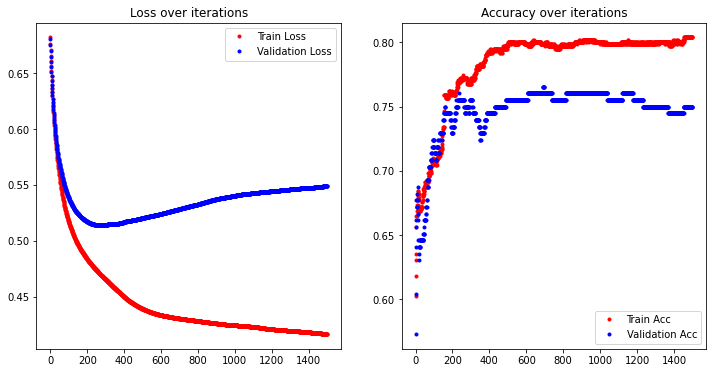

In [31]:
n = len(run_hist_2.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (run_hist_2.history["loss"]),'r.', label="Train Loss")
ax.plot(range(n), (run_hist_2.history["val_loss"]),'b.', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (run_hist_2.history["accuracy"]),'r.', label="Train Acc")
ax.plot(range(n), (run_hist_2.history["val_accuracy"]),'b.', label="Validation Acc")
ax.legend(loc='lower right')
ax.set_title('Accuracy over iterations')

6/6 [==============================] - 0s 1ms/step

accuracy is 0.750
roc-auc is 0.795


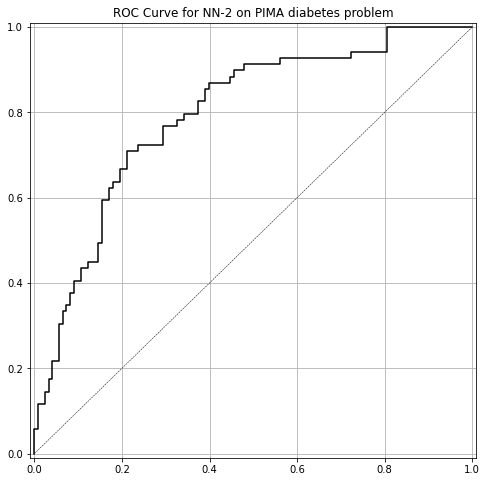

In [32]:
#y_pred_class_nn_2 = model_2.predict_classes(X_test_norm)
y_pred_prob_nn_2 = model_2.predict(X_test_norm)
y_pred_class_nn_2=pd.DataFrame(y_pred_prob_nn_2)
y_pred_class_nn_2=np.array(y_pred_class_nn_2[0].apply(lambda x : 0 if x<0.5 else 1))
y_pred_class_nn_2=y_pred_class_nn_2.reshape(-1,1)

print('')
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_2)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_2)))

plot_roc(y_test, y_pred_prob_nn_2, 'NN-2')
### END SOLUTION

---
### Machine Learning Foundation (C) 2020 IBM Corporation